# Capstone

Project follows five day Gen AI course by Google. [Blog Article](https://pawanmsr.github.io/post/classical-ml) contains classsical machine learning, and the experiments done here and on Vertex AI.

In [1]:
# Remove unused packages from Kaggle's base image that conflict.
!pip uninstall -qqy jupyterlab kfp jupyterlab-lsp
# Comment out on local notebook.

# Additional Installation
!pip install -U --quiet google-genai qdrant-client langgraph
!pip install -U --quiet langchain-community langchain-core langchain-google-genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.7/159.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.7/306.7 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 50.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 92.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 16.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beh

## AI Studio

1. Visit [Google AI Studio](https://aistudio.google.com/apikey) and generate an API Key.
2. The API Key(s) must be added as *secret* through *Add-ons* (in menu bar).
3. Check the box beside the Key to activate it.

On local notebook, export the variable: `export GOOGLE_API_KEY=$GOOGLE_API_KEY` and modify the succeeding cell before running. Additionally, it would be beneficial to install Google Cloud CLI.

In [2]:
import os
from pprint import pprint
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

# If project does not exist, then use Google API Key.
GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")

LOCATION = "us-central1"
# If project exists on Google Cloud then use the project id.
PROJECT_ID = user_secrets.get_secret("PROJECT_ID")

# Upload file in bucket and provide location as gsutil key.
ENGINE_IMAGE_FILE = user_secrets.get_secret("ENGINE_IMAGE_KEY")
HELICOPTER_IMAGE_FILE = user_secrets.get_secret("HELICOPTER_IMAGE_KEY")
HELICOPTER_VIDEO_FILE = user_secrets.get_secret("HELICOPTER_VIDEO_KEY")

# Google Cloud SDK
USER_CREDENTIAL = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(USER_CREDENTIAL)

os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

## Imports and Usage

Showcase several different use cases.

1. Controlled Generation
2. Few-Shot Prompting
3. Document Understanding
4. Image Understanding
5. Video Understanding
6. Audio Understanding
7. Function Calling
8. Agents
9. Evaluation
10. Embedding
11. RAG
12. Vector

Although there are more use cases that can be domonstrated, I will keep them for later. All of the above will require importing many different packages.

### Note

Instead of structuring all inputs into a single variable, I have deliberately kept them loose. Naming variables in this way is often self-explanatory.

In [3]:
from google import genai
from google.genai import types
from google.api_core import retry

from typing import Optional, Annotated, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langchain_google_genai import ChatGoogleGenerativeAI
# Langchain is custom to organisation. Checkout listing for different options.

from qdrant_client import QdrantClient, models

from IPython.display import HTML, Markdown, display, Image

genai.__version__

'1.11.0'

In [4]:
# Initialize client and instruct protocol for retry.

vclient = genai.Client(
    vertexai = True,
    project = PROJECT_ID,
    location = LOCATION
)

client = genai.Client(
    api_key=GOOGLE_API_KEY,
)

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = \
    retry.Retry(predicate=is_retriable)(genai.models.Models.generate_content)

In [5]:
# Many different models are present but let's stick to one.

MODEL = "gemini-2.0-flash"
IMAGEN = "imagen-3.0-generate-002"
VEO = "veo-2.0-generate-001"
EMBEDDING = list()

for model in client.models.list():
    if 'embedContent' in model.supported_actions:
        EMBEDDING.append(model.name)

## Controlled Generation

Obtain output in a specific format.

- Specify JavaScript Object Notation (JSON) request and response schema.
- Dictionary-List in Python is analogous with JSON.
- Fields
    1. **cachedContent** is optional string
    2. **contents**
        1. **role** is an optional string with values "user" or "model". First query will be with user and then it will involve user and model.
        2. **parts** can be **text**, **inlineData**, **fileData**, **functionCall**, **functionResponse** and **videoMetadata**. I will use **inlineData** of an image and **fileData** of a video stored on Google Cloud Storage. The later will have **vedioMetadata**. I will also perform *function calling*.
    3. **systemInstruction** instructs model to output in a certain way. I will instruct the model to present a concise response as well as an elaborated response.
    4. I will not control the **safetySetting** unless the outputs are distasteful.
    5. **generationConfig** controls the variance. I will test **temperature**, **topP**, **presencePenalty**, **frequencyPenalty**. The last couple will be used to test for aliteration generation. All of them will have **responseMimeType** and few of them will also have **responseSchema**. Rest of the options are either preview or not worth consideration.
    6. **labels** will contain key-value pair.
- Most of the response values are printed.

Conversations will be about Music, Books and Sports.

In [6]:
# Iteration Constants

ATTEMPTS = 3

TEMPERATURES = [0.0, 0.5, 1.0, 1.5, 2.0]
TOP_PS = [0.1, 0.2, 0.4, 0.8, 1.0]
TOP_KS = [2, 4, 16, 256]
PRESENCE_PENALTIES = [-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5]
FREQUENCY_PENALTIES = [-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5]

COMMON_TEXT = {
    "music": "What are common musical instruments?",
    "sport": "What are some common sports?",
    "instruction": "single list",
}

IMAGE_TEXT = {
    "v10": "What kind of engine is this?",
    "rah66": "What do you see in this image?",
    "ace": "Produce an image of generation five air dominance aircraft."
}

VIDEO_TEXT = {
    "dhruv": "What kind of Helicopter is flying in this clip?",
    "vortex": "Produce a short animation of vortex flow from submarine propellors."
}

SPECIFIC_TEXT = {
    "treasure island": "Tell me about Treasure Island.",
    "tintin by herge": "Do you know the secret of the unicorn?"
}

PENALTY_TEXT = {
    "toung twister": "Tell me a toung twister.",
    "instruction": "single sentence",
}

class Book(BaseModel):
    genre: Optional[str]
    pages: Optional[int]
    published: Optional[int]
    format: Optional[str]
    type: Optional[str]
    protagonist: Optional[str]
    antagonist: Optional[str]
    review: Optional[int]
    author: Optional[str]

In [7]:
# Generation functions.

def test_generation(contents: list, config: dict = {}) -> str:
    response = client.models.generate_content(
        model = MODEL,
        config = config,
        contents = contents
    )
    
    return response.text

def vertex_generation(contents: list, config: dict = {}) -> str:
    response = vclient.models.generate_content(
        model = MODEL,
        config = config,
        contents = contents
    )
    
    return response.text

def image_generation(content: str, config: dict = {}) -> list:
    response = vclient.models.generate_images(
        model = IMAGEN,
        prompt = content,
        config = config
    )

    return response.generated_images

def video_generation(content: str, config: dict = {}) -> list:
    response = vclient.models.generate_videos(
        model = VEO,
        prompt = content,
        config = config
    )

    return response.generated_videos

### Simple Conversation

Let's talk about dogs . . . or maybe something else!

In [8]:
# Experiment 1: Listing
contents = types.Content(
    role = "user",
    parts = [types.Part.from_text(text = COMMON_TEXT["music"])]
)

text = test_generation(contents)
print(text)

Musical instruments are incredibly diverse, but here's a breakdown of common ones, categorized by how they produce sound:

**1. String Instruments (Chordophones):** These instruments produce sound by vibrating strings.

*   **Plucked:**
    *   **Guitar:** Acoustic, electric, bass (very common in various genres)
    *   **Ukulele:** Small, four-stringed, often associated with Hawaiian music
    *   **Harp:** Large, multi-stringed, often used in classical music
    *   **Mandolin:** Small, pear-shaped, often used in folk and bluegrass music
    *   **Banjo:** Typically has a round body covered with a skin or head, popular in folk and bluegrass
    *   **Sitar:** Indian stringed instrument, prominent in Hindustani classical music
*   **Bowed:**
    *   **Violin (Fiddle):** High-pitched, versatile, used in classical, folk, and pop
    *   **Viola:** Larger than a violin, lower in pitch
    *   **Cello:** Lower than a viola, rich and resonant sound
    *   **Double Bass (Upright Bass):** L

In [9]:
# Experiment 1.1: Listing with system instruction, temperature, top_p and top_k.

contents = types.Content(
    role = "user",
    parts = [types.Part.from_text(text = COMMON_TEXT["sport"])]
)

for t in TEMPERATURES:
    print(f"### Temperature: {t}\n")

    for attempt in range(ATTEMPTS):
        print(f"#### Attempt {attempt + 1}\n")
        config = types.GenerateContentConfig(
            system_instruction = COMMON_TEXT["instruction"],
            max_output_tokens = 16,
            temperature = t,
        )
    
        text = test_generation(contents, config)
        print(text, '\n')

for p in TOP_PS:
    print(f"### P: {p}\n")

    for attempt in range(ATTEMPTS):
        print(f"#### Attempt {attempt + 1}\n")
        config = types.GenerateContentConfig(
            system_instruction = COMMON_TEXT["instruction"],
            max_output_tokens = 16,
            temperature = 1.0,
            top_p = p
        )
    
        text = test_generation(contents, config)
        print(text, '\n')

for k in TOP_KS:
    print(f"### K: {k}\n")

    for attempt in range(ATTEMPTS):
        print(f"#### Attempt {attempt + 1}\n")
        config = types.GenerateContentConfig(
            system_instruction = COMMON_TEXT["instruction"],
            max_output_tokens = 16,
            temperature = 1.0,
            top_p = 1.0,
            top_k = k,
        )
    
        text = test_generation(contents, config)
        print(text, '\n')

### Temperature: 0.0

#### Attempt 1

*   Soccer (Football)
*   Basketball
*   Baseball
* 

#### Attempt 2

*   Soccer (Football)
*   Basketball
*   Baseball
* 

#### Attempt 3

*   Soccer (Football)
*   Basketball
*   Baseball
* 

### Temperature: 0.5

#### Attempt 1

*   Soccer (Football)
*   Basketball
*   Baseball
* 

#### Attempt 2

*   Soccer (Football)
*   Basketball
*   American Football
 

#### Attempt 3

*   Soccer
*   Basketball
*   American Football
*   Baseball 

### Temperature: 1.0

#### Attempt 1

*   Football (Soccer)
*   Basketball
*   Baseball
* 

#### Attempt 2

*   Soccer (Football)
*   Basketball
*   Baseball
* 

#### Attempt 3

*   Basketball
*   Soccer (Football)
*   American Football
 

### Temperature: 1.5

#### Attempt 1

*   Basketball
*   Soccer
*   American Football
*   Baseball 

#### Attempt 2

*   Soccer
*   Basketball
*   American Football
*   Baseball 

#### Attempt 3

*   Soccer
*   Basketball
*   Baseball
*   American Football 

### Temperature: 2.0

As we increase the temperature settings and cumulative probability for selection, we start getting more diverse results. This is subject to value of k for top k selected elements: the greater k enables more options to choose from.

In [10]:
# Experiment 2: Follow response schema.

contents = types.Content(
    role = "user",
    parts = [types.Part.from_text(text = SPECIFIC_TEXT["treasure island"])]
)

config = types.GenerateContentConfig(
    response_mime_type = "application/json",
    response_schema = Book,
)

text = test_generation(contents, config)
print(text)

{
  "genre": "Adventure",
  "pages": 296,
  "published": 1883,
  "format": "Hardcover",
  "type": "Fiction",
  "protagonist": "Jim Hawkins",
  "antagonist": "Long John Silver",
  "review": 4,
  "author": "Robert Louis Stevenson"
}


In [11]:
# Experiment 2.1: Ambiguious question.

contents = types.Content(
    role = "user",
    parts = [types.Part.from_text(text = SPECIFIC_TEXT["tintin by herge"])]
)

config = types.GenerateContentConfig(
    response_mime_type = "application/json",
    response_schema = Book,
)

text = test_generation(contents, config)
print(text)

{
  "genre": "fantasy",
  "pages": 300,
  "published": 2023,
  "format": "hardcover",
  "type": "novel",
  "protagonist": "Elara",
  "antagonist": "The Shadow King",
  "review": 4,
  "author": "Anya Blackwood"
}


In [12]:
# Experiment 3: Toung twister with presence and frequency penalty.

for presence_penalty in PRESENCE_PENALTIES:
    print(f"### Presence Penalty: {presence_penalty}\n")
    contents = types.Content(
        role = "user",
        parts = [types.Part.from_text(text = PENALTY_TEXT["toung twister"])]
    )
    
    config = types.GenerateContentConfig(
        system_instruction = PENALTY_TEXT["instruction"],
        presence_penalty = presence_penalty,
        temperature = 1.0,
        top_p = 1.0,
        top_k = 32
    )
    
    text = test_generation(contents, config)
    print(text)

for frequency_penalty in FREQUENCY_PENALTIES:
    print(f"### Frequency Penalty: {frequency_penalty}\n")
    contents = types.Content(
        role = "user",
        parts = [types.Part.from_text(text = PENALTY_TEXT["toung twister"])]
    )
    
    config = types.GenerateContentConfig(
        system_instruction = PENALTY_TEXT["instruction"],
        frequency_penalty = frequency_penalty,
        temperature = 1.0,
        top_p = 1.0,
        top_k = 32
    )
    
    text = test_generation(contents, config)
    print(text)

### Presence Penalty: -2.0

How much wood would a woodchuck chuck if a woodchuck could chuck wood?

### Presence Penalty: -1.5

Peter Piper picked a peck of pickled peppers.

### Presence Penalty: -1.0

How much wood would a woodchuck chuck if a woodchuck could chuck wood?

### Presence Penalty: -0.5

How much wood would a woodchuck chuck if a woodchuck could chuck wood?

### Presence Penalty: 0.0

How much wood would a woodchuck chuck if a woodchuck could chuck wood?

### Presence Penalty: 0.5

How much wood would a woodchuck chuck if a woodchuck could chuck wood?

### Presence Penalty: 1.0

How much wood would a woodchuck chuck if a woodchuck could chuck wood?

### Presence Penalty: 1.5

How much wood would a woodchuck chuck if a woodchuck could chuck wood?

### Frequency Penalty: -2.0

How much wood would a woodchuck chuck if a woodchuck could chuck wood?

### Frequency Penalty: -1.5

How much wood would a woodchuck chuck if a woodchuck could chuck wood?

### Frequency Penalty: -1.0

## Few Shot Prompting

One of the outputs above seems a little wrong. Let's give the model one or few hint(s).

In [13]:
CONTEXT = {
    "tintin by herge": "Herge authored many comics as part of a series called 'Adventures of Tintin'. \
        Some of my favourites were: \
        - 'The Calculus Affair' published in 1956 \
        - 'Explorers On The Moon' published in 1954 \
        - 'Destination Moon' published in 1953 \
        - 'Flight 714 To Sydney' published in 1968 \
        - 'The Shooting Star' published in 1942 \
    "
}

for key in CONTEXT:
    SPECIFIC_TEXT[key] = CONTEXT[key] + SPECIFIC_TEXT[key]

In [14]:
# Experiment 4: Ambiguious question with context. Few Shot.

contents = types.Content(
    role = "user",
    parts = [types.Part.from_text(text = SPECIFIC_TEXT["tintin by herge"])]
)

config = types.GenerateContentConfig(
    response_mime_type = "application/json",
    response_schema = Book,
)

text = test_generation(contents, config)
print(text)

{
  "genre": "comic book",
  "pages": null,
  "published": null,
  "format": "paperback",
  "type": "fiction",
  "protagonist": "Tintin",
  "antagonist": null,
  "review": null,
  "author": "Herge"
}


#### Evaluation

The response is definitely not complete but it seems right on the ones it did supply.

## Embeddings and Vector Databases

Of the many choices available for vector databases, such as chromadb and pinecone, let's use Qdrant. Production would require a server to host vector database. Since this is a demonstration, we will use it in memory.

1. Semantic similarity on stanzas of my poems.
2. Classification on jokes.

In [15]:
qclient = QdrantClient(":memory:")

TITLE = "CAP on Stones for CAPSTONE"

TASK_TYPES = [
    "semantic_similarity",
    "classification",
    "clustering",
    "question_answering",
    "code_retrieval_query"
]

DIMENSION = 768

POEM = [
    "When I am bored of my daily chores, \
    I embark on a trip to distant shores.",
    "The shores are full of pebbles and stones, \
    Most of them are alike, stacked up in zones.",
    "I often throw them, to see if they snap, \
    But they stay intact, and seldom crack.",
    "I guess, the stones are not only consistent, \
    But also available, and partition tolerant."
]

# My poem contains four stanzas.
# Let's test out semantic similarity between each pair of stanzas.
# I suspect the semantic similarity will be moderate.

# Embedding models available are named in EMBEDDING.
print('\n'.join(EMBEDDING))

models/embedding-001
models/text-embedding-004
models/gemini-embedding-exp-03-07
models/gemini-embedding-exp


In [16]:
# Gemeni Embedding for Semantic Similarity.
contents = [
    types.Content(
        role = "user",
        parts = [types.Part.from_text(text = stanza)]
    ) for stanza in POEM
]

config = types.EmbedContentConfig(
    task_type = TASK_TYPES[0],
    output_dimensionality = DIMENSION,
)

response = client.models.embed_content(
    model = EMBEDDING[0],
    contents = contents,
    config = config
)

qclient.delete_collection(collection_name = TITLE)
qclient.create_collection(
    collection_name = TITLE,
    vectors_config=models.VectorParams(size = DIMENSION, distance = models.Distance.DOT)
)

for i, embedding in enumerate(response.embeddings):
    qclient.upsert(
        collection_name = TITLE,
        points = [
            models.PointStruct(
                id = i,
                payload = {
                    "stanza" : i + 1
                },
                vector = embedding.values
            ) for i, embedding in enumerate(response.embeddings)
        ],
    )

In [17]:
# Let's perform a ranked search.

THEOREM = "CAP Theorem"

contents = types.Content(
    role = "user",
    parts = [types.Part.from_text(text = THEOREM)]
)

config = types.EmbedContentConfig(
    task_type = TASK_TYPES[0],
    output_dimensionality = DIMENSION,
)

response = client.models.embed_content(
    model = EMBEDDING[0],
    contents = contents,
    config = config
)

qresponse = qclient.query_points(
    collection_name = TITLE,
    query = response.embeddings[-1].values,
)

for i, point in enumerate(qresponse.points):
    print(f"{point.payload} has score: {point.score} and is ranked {i + 1}")

{'stanza': 4} has score: 0.5534311004761003 and is ranked 1
{'stanza': 2} has score: 0.5129857408957478 and is ranked 2
{'stanza': 3} has score: 0.482242845505272 and is ranked 3
{'stanza': 1} has score: 0.46766045527197375 and is ranked 4


#### Evaluation

The answer is in Stanza 4 of the poem. Embedding of Stanza 4 was added to vector database with id of 3, which scored highest in semantic similarity with embedding of "CAP Theorem".

## Multi-Modal Understanding

Models can understand images, audio-video and documents.

### Retrieval Augmented Generation

Document understanding. Let's combine the above poem and add a query to see if the model can produce a reasonable answer.

In [18]:
QUESTION = "Where does the author go when they are bored?"
DOCUMENT = ' '.join(POEM)

contents = types.Content(
    role = "user",
    parts = [types.Part.from_text(text = f"Query: {QUESTION}\nDocument: {DOCUMENT}")]
)

answer = test_generation(contents)
print(answer)

The author goes to distant shores when they are bored.



#### Evaluation

Pretty straight forward and accurate reply - the kind one expects. I would have have veered off-course though.

### Image

Query on photographs.

In [19]:
contents = [
    types.Part.from_text(text = IMAGE_TEXT["v10"]),
    types.Part.from_uri(
        file_uri = ENGINE_IMAGE_FILE,
        mime_type = 'image/jpeg',
    )
]

description = vertex_generation(contents)
print(description, '\n')

contents = [
    types.Part.from_text(text = IMAGE_TEXT["rah66"]),
    types.Part.from_uri(
        file_uri = HELICOPTER_IMAGE_FILE,
        mime_type = 'image/webp',
    )
]

description = vertex_generation(contents)
print(description, '\n')

Based on the images, this appears to be a V-engine, likely a V12. This is inferred from the cylinder head configuration, the number of exhaust manifolds visible, and the overall size and structure of the engine. The blue block and silver heads are common color schemes for display engines. Also, the overall design suggests it could be a diesel engine. 

The image shows a Sikorsky-Boeing SB-1 Defiant helicopter flying over a swampy, forested area. The helicopter is in the foreground, and the background is filled with trees and waterways. The helicopter appears to be in flight, with its rotors spinning. 



#### Evaluation

**V12** are slightly larger than **V10**. On top of that I supplied an image of engine used in heavy vehicles instead of sports vehicles. **V10** in heavy vehicles will have a similar form factor to that of slightly smaller displacement **V12**.

Incorrect guess on the helicopter, but to be fair Comanche is somewhat of a legend.

### Video Understanding

I will supply a short (10 second) video of Dhruv Helicopters and query about the scene.

In [20]:
contents = [
    types.Part.from_text(text = VIDEO_TEXT["dhruv"]),
    types.Part.from_uri(
        file_uri = HELICOPTER_VIDEO_FILE,
        mime_type = 'video/mp4',
    )
]

description = vertex_generation(contents)
print(description, '\n')

Based on the distinctive shape and appearance in the clip, the helicopters are HAL Dhruv. They are also known as Advanced Light Helicopters (ALH). 



#### Evaluation

I used one of the clips I had in my camera roll. The description is accurate.

### Image and Video Generation

Vertex AI uses Imagen and Veo for image generation and video generation respectively. These are not available to free tier users.

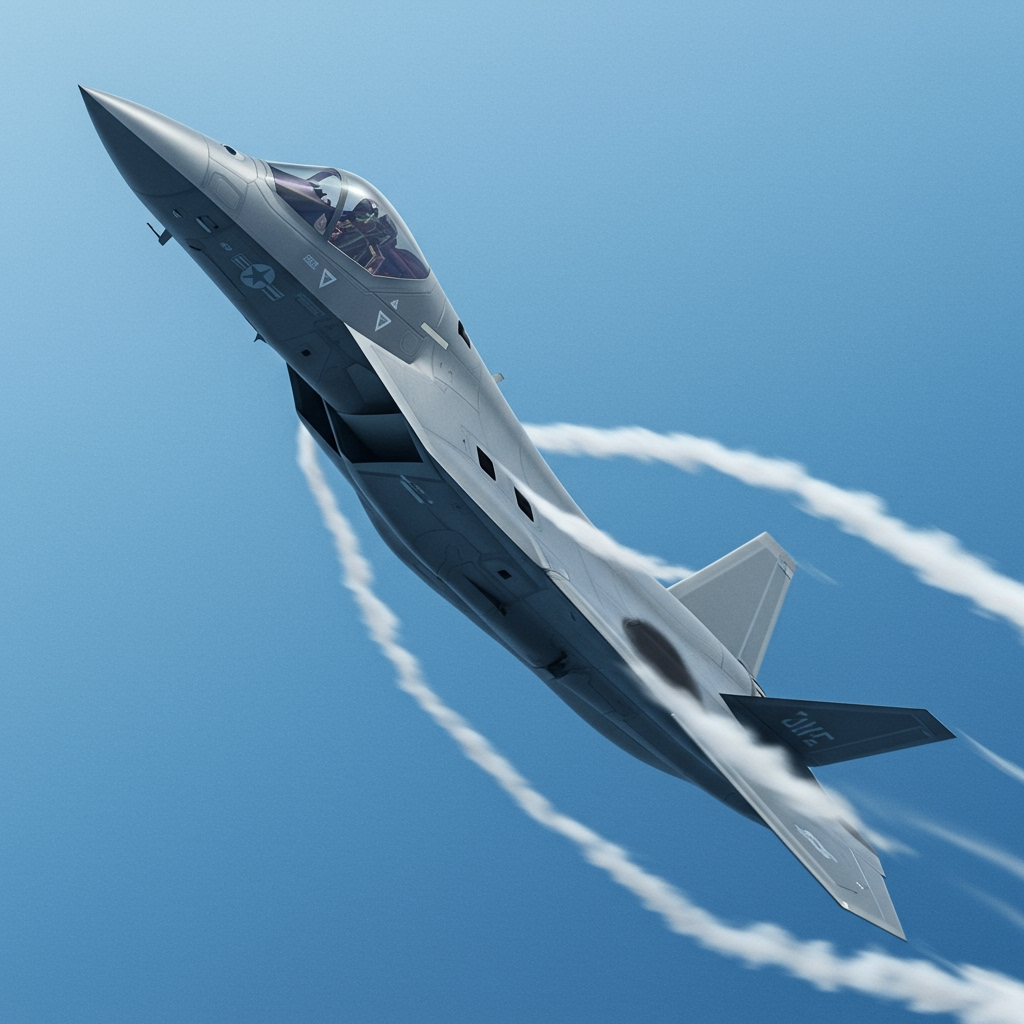

In [21]:
content = IMAGE_TEXT["ace"]

config = types.GenerateImagesConfig(
    number_of_images = 1,
    include_rai_reason = True,
    output_mime_type = 'image/jpeg',
)

try:
    images = image_generation(content, config)
    images[0].image.show()
except:
    print("Billed Users Only :-(")

In [22]:
content = VIDEO_TEXT["vortex"]

config = types.GenerateVideosConfig(
    fps = 16,
    number_of_videos = 1,
    duration_seconds = 8,
    enhance_prompt = True,
)

try:
    videos = video_generation(content, config)
    videos[0].video.show()
except:
    print("Billed Users Only :-(")

Billed Users Only :-(


#### Evaluation

There is no objective way to evaluate image or video generation, but those that are generated are pretty impressive (however erroneous they might be).

## Invoking Functions

Create a few functions and then query the model for data.

In [23]:
def arithmetic_progression(a: float, n: int, d: float) -> int:
    """nth term of arithmetic progression"""
    return a + (n - 1) * d

def geometric_progression(a: float, n: int, r: float) -> int:
    """nth term of geometric progression"""
    return a * r ** (n - 1)

INSTRUCTION = "Arithmetic progression or AP starts with first term a \
    and every subsequent term adds a common difference d. \
    Geometric progression or GP starts with first term a \
    and every subsequent term multiplies a common ratio r."

# Start a chat with automatic function calling enabled.
chat = client.chats.create(
    model = MODEL,
    config = types.GenerateContentConfig(
        system_instruction=INSTRUCTION,
        tools=[arithmetic_progression, geometric_progression],
    ),
)

In [24]:
response = chat.send_message(
    "What is the second term in AP of 5 with common difference 1?"
)

print(response.text, '\n')

response = chat.send_message(
    "What is the fifth term in GP with first term 5 \
    and progression ratio 1?"
)

print(response.text, '\n')

response = chat.send_message(
    "Calculate the 10th term in GP with common ratio of two and \
    first term equal to seventh term of AP starting with five \
    and having common difference of minus 1.")

print(response.text, '\n')

The second term is 6. 

The fifth term is 5. 

The 10th term in GP is -512. 



#### Evaluation

Although, default parameters are not supported, the responses are pretty accurate for simple functions.

## Agents

Agents are supercharged models. I will develop a simple dual agent system. A user is commanding a fleet. Ship's captain maintains the bearings and system configuration, whereas the navigator provides bearings.

In [25]:
RADIO_INSTRUCTION = (
    "system",
    "Radio operator's job is to provide three values: \
    power, depth and bearing. Power should be an integer between 0 and 100, \
    depth should be an integer between 0 and 500, \
    bearing should be an integer between 0 and 360. \
    Reply with the three values for every query."
)

CAPTAIN_INSTRUCTION = (
    "system",
    "Captain's job is to check if the ship can take course. \
    The power cannot be above 85 to avoid detection. \
    The depth should not be less than 20 and definitely not more 200. \
    Any value of bearing between 0 and 360 are possible. \
    Reply AYE if all values are correct or request assistance."
)

SSN = {"configurable": {"thread_id": "1"}} # First ship. Attack Submarine.
SSGN = {"configurable": {"thread_id": "2"}} # Second ship. Ranged Submarine.

class State(TypedDict):
    power: int # Control lever for power.
    depth: int # Depth in meters.
    bearing: int # Direction in which the ship is headed.
    messages: Annotated[list, add_messages]

builder = StateGraph(State)
llm = ChatGoogleGenerativeAI(model = MODEL)

def radio_operator(state: State) -> Command[Literal["captain"]]:
    contents = [RADIO_INSTRUCTION] + state["messages"]
    return Command(
        goto="captain",
        update = {"messages": [llm.invoke(contents)]}
    )

def captain(state: State) -> Command[Literal["tools", END]]:
    contents = [CAPTAIN_INSTRUCTION] + state["messages"]
    return Command(
        goto="tools",
        update = {"messages": [llm.invoke(contents)]}
    )

@tool
def commander(power: int, depth: int, bearing: int,
    tool_call_id: Annotated[str, InjectedToolCallId]) -> str:
    """Request assistance from commander."""
    command = interrupt({
        "power": power,
        "depth": depth,
        "bearing": bearing
    })

    if command.get("correct", "").lower().startswith("y"):
        verified_power = power
        verified_depth = depth
        verified_bearing = bearing
        response = "Correct"
    else:
        verified_power = commander.get("power", power)
        verified_depth = commander.get("depth", depth)
        verified_bearing = commander.get("bearing", bearing)
        response = f"Made a correction: {command}"

    state_update = {
        "power": verified_power,
        "depth": verified_depth,
        "bearing": verified_bearing,
        "messages": [ToolMessage(response, tool_call_id = tool_call_id)],
    }

    return Command(state = state_update)

command_center = ToolNode(tools=[commander])

builder.add_node("radio_operator", radio_operator)
builder.add_node("captain", captain)
builder.add_node("tools", command_center)
builder.add_conditional_edges(
    "radio_operator",
    tools_condition,
)

builder.set_entry_point("radio_operator")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [26]:
def set_sail(ship: dict) -> None:
    begin = "Hi, chart course."
    events = graph.stream(
        {"messages": [{"role": "user", "content": begin}]},
        ship,
        stream_mode = "values"
    )
    
    for event in events:
        if "messages" in event:
            event["messages"][-1].pretty_print()

set_sail(SSN)
set_sail(SSGN)

================================ Human Message =================================

Hi, chart course.
================================== Ai Message ==================================

Power: 50, Depth: 250, Bearing: 180
================================== Ai Message ==================================
================================== Ai Message ==================================
================================ Human Message =================================

Hi, chart course.
================================== Ai Message ==================================

Power: 62, Depth: 245, Bearing: 180
================================== Ai Message ==================================
================================== Ai Message ==================================


I guess it takes some effort to get the langgraph right, specially if it is a multi-agent system. I will need to do it outside the notebook environment.

This was fun!

## References

- Documentations and API References
